# Voter model - bipartite network
In this notebook, we run our configuration of the voter model on a biparite network. We ran $m=50$ independent realizations of the voter model, each realizaton has $10^6$ repeats. We ploted the number of changes per number of repeats (how many nodes fliped / changed the state), so we can see how the process evolve over the time. In order to validate the model, we chose 3/10-_ths_ as a testing set, run the model, based on values which the model assigned to the training data, we determined the confusion matrix, ROC curve and total accuracy. 

In [1]:
import voter_model as vm
from kassiopea import Kassiopea
from tools import plot_roc, plot_pdf, round_acc, round_acc2

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import random as r
import csv
import time

In [2]:
start = time.time()
K = Kassiopea()

# Statistics of initial states counts
blacklisted = 0
whitelisted = 0
unknown = 0

# Add network"s nodes and edges from file
with open("data/data.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Create domain"s nodes
        if row["domain"] not in K.get_nodes():
            label = int(row["domain_state"])
            if label == 0:
                zea = 1
                unknown += 1
            else:
                zea = 0
                if label == 1:
                    whitelisted += 1
                else:
                    blacklisted += 1
                    
            K.add_node(row["domain"], zea=zea, label=label)
        
        # Create ip"s nodes 
        if row["ip"] not in K.get_nodes():
            label = int(row["ip_state"])
            if label == 0:
                zea = 1
                unknown += 1
            else:
                zea = 0
                if label == 1:
                    whitelisted += 1
                else:
                    blacklisted += 1
    
            K.add_node(row["ip"], zea=zea, label=label)
        
        # Create an edge between IP <-> Domain
        # if (row["domain"], row["ip"]) not in K.list_edges:
        K.add_edge(row["domain"], row["ip"])
        
print(f"Network is created in: {round(time.time() - start, 3)}s")

Network is created in: 533.34


As the network is created, nodes and edges are added, then we can run realisations of Voter Model.

In [3]:
# As the original labels and "zeas" will be changed, we deepcopy them 
original_labels = deepcopy(K.label)
original_zeas = deepcopy(K.zea)

# Selecting the "zeas" from the dataset
zeas = [i for i, v in enumerate(original_zeas) if v == 0]
num_zeas = len(zeas)

In [4]:
rate = {}
num_nodes = len(K.get_nodes())
stopping_time = []

# Num of realisation of Voter Model
m = 50

# Fraction of the trainning data set
accs = 3 / 10
num_ch = int(num_zeas * accs)
random_z = r.sample(zeas, num_ch)

# Set the labels to original labels
K.update_label(original_labels)
K.update_zea(original_zeas)

# Training "zeas" are labeled as unknown
for n in random_z:
    K.update_zea_node(n, 1)
    K.update_label_node(n, 0)

# Deepcopy current labels with training "zeas"
labels = deepcopy(K.label)
rate = [0] * num_nodes 
hists = {}

un = []

# Running m independent realisation of Voter Model
for i in range(m):
    # Set the labels to original ones
    stats = 0
    K.update_label(labels)
    stop = time.time()
    hist, x, st, u = vm.voter_model_realisation(K, 6, 0.01)
    hists[i] = hist
    un.append(u)
    print(f"Time used for this realization: {round(time.time() - stop, 3)}s realization: {i + 1} / {m}")
    
    # Assign rate for later computing of long term average
    for n in range(num_nodes):
        rate[n] += int(K.label[n])

Time used for this realization: 5.44 realization: 1 / 50
Time used for this realization: 5.609 realization: 2 / 50
Time used for this realization: 5.332 realization: 3 / 50
Time used for this realization: 5.275 realization: 4 / 50
Time used for this realization: 5.087 realization: 5 / 50
Time used for this realization: 5.827 realization: 6 / 50
Time used for this realization: 5.237 realization: 7 / 50
Time used for this realization: 5.373 realization: 8 / 50
Time used for this realization: 5.526 realization: 9 / 50
Time used for this realization: 5.285 realization: 10 / 50
Time used for this realization: 5.354 realization: 11 / 50
Time used for this realization: 5.333 realization: 12 / 50
Time used for this realization: 5.204 realization: 13 / 50
Time used for this realization: 5.27 realization: 14 / 50
Time used for this realization: 5.452 realization: 15 / 50
Time used for this realization: 5.507 realization: 16 / 50
Time used for this realization: 5.061 realization: 17 / 50
Time use

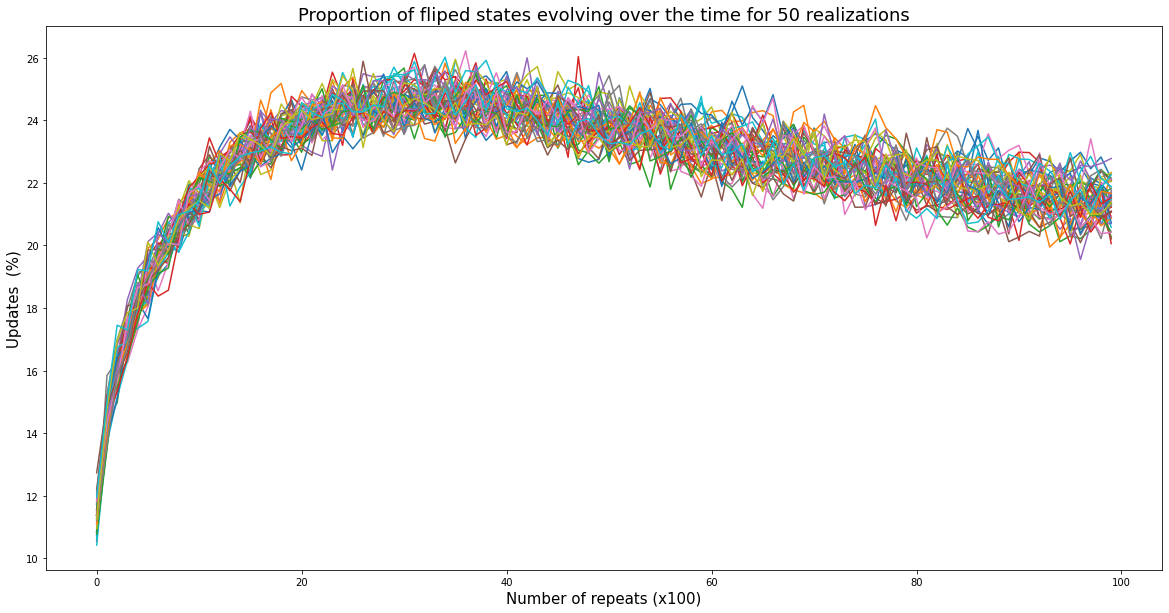

In [11]:
plt.figure(figsize=(20, 10))
plt.title(f"Proportion of fliped states evolving over the time for {m} realizations", fontsize=18)
plt.xlabel("Number of repeats (x100)", fontsize=15)
plt.ylabel("Updates  (%)", fontsize=15)
length = len(hists)
last = [0] * length

for i in range(length):
    plt.plot(np.array(hists[i][:]) * 100)

plt.show()

After m realisations are run we can make some statistics and take a look on accuracy. Under confustion matrix we understand: 
$$\begin{bmatrix}
    TrueWhitelisted & FlaseWhitelisted \\
    FalseBlacklisted & TrueBlacklisted \\
\end{bmatrix}$$

In [6]:
# Confusion matrix
confusion_matrix = np.zeros((2, 2))


def round_1(x):
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0
    
for n in random_z: 
    if original_labels[n] == round_1(rate[n]):
        if original_labels[n] == 1:
            confusion_matrix[0][0] += 1
        else:
            confusion_matrix[1][1] += 1
    else:
        if original_labels[n] == 1:
            confusion_matrix[0][1] += 1
        else:
            confusion_matrix[1][0] += 1
            
print("Confusion matrix, relative numbers")  
print(confusion_matrix[0] / (confusion_matrix[0][1] + confusion_matrix[0][0]))
print(confusion_matrix[1] / (confusion_matrix[1][1] + confusion_matrix[1][0]), "\n")
print("Confusion matrix, absolute numbers")
print(confusion_matrix)

print("Accuracy:", round((confusion_matrix[0][0] + confusion_matrix[1][1]) / len(random_z), 3), "%\n")

blacklisted_f = 0
whitelisted_f = 0
unknown_f = 0

for n in range(num_nodes):
    if (rate[n] / m) < 0:
        blacklisted_f += 1
    elif (rate[n] / m) > 0:
        whitelisted_f += 1
    else:
        unknown_f += 1
        
print("Statistics about states")
print(f"#Uknown: (before, after): {(unknown_f, unknown)}")
print(f"#Whitelisted: (before, after): {(whitelisted_f, whitelisted)}")
print(f"#Blacklisted: (before, after): {(blacklisted_f, blacklisted)}\n")

print(f"Ratio whitelisted / blacklisted in the end: {round(whitelisted_f / blacklisted_f, 3)}")
print(f"Ratio whitelisted / blacklisted in the beginning: {round(whitelisted / blacklisted, 3)}")
print(f"#nodes: {len(K.get_nodes())}")
print(f"#edges: {len(K.get_edges())}")

Confusion matrix, relative numbers
[0.34358974 0.65641026]
[0.03693931 0.96306069] 

Confusion matrix, absolute numbers
[[ 67. 128.]
 [ 28. 730.]]
Accuracy: 0.836 %

Statistics about states
#Uknown: (before, after): (26288, 93674)
#Whitelisted: (before, after): (18323, 643)
#Blacklisted: (before, after): (52242, 2536)

Ratio whitelisted / blacklisted in the end: 0.351
Ratio whitelisted / blacklisted in the beginning: 0.254
#nodes: 96853
#edges: 137289


In this section, we would like to present ROC curve and comparison between rate, eigenvalue centrality, degree distibution

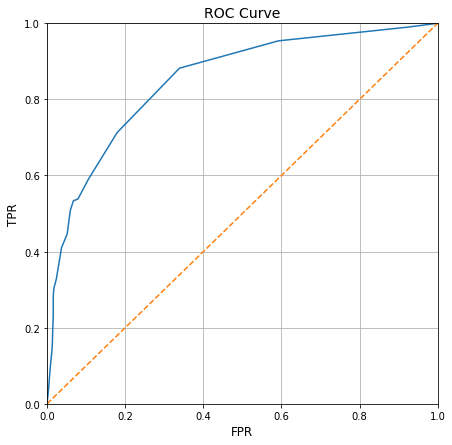

In [7]:
l = 20 
wl = [(rate[n] / m) for n in random_z if original_labels[n] == 1]
bl = [(rate[n] / m) for n in random_z if original_labels[n] == -1]

hist_wl, bins = np.histogram(wl, bins=np.linspace(-1, 1, l + 1), density=True)
hist_bl, bins = np.histogram(bl, bins=np.linspace(-1, 1, l + 1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plot_roc(hist_bl, hist_wl, ax, np.arange(0, l))
plt.show()

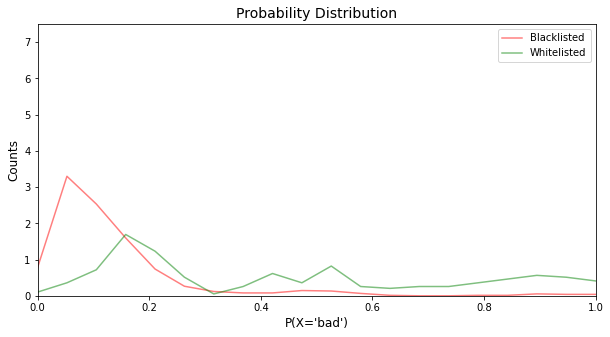

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
x = np.linspace(0, 1, num=l)
plot_pdf(hist_bl, hist_wl, ax, x)
plt.show()

### Sources:
[1] Receiver Operating Characteristic Curves Demystified (in Python), https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0